# Basic

This notebook implements basic network for MNIST.
The training code's backbone is largely from https://github.com/zergtant/pytorch-handbook/blob/master/chapter3/3.2-mnist.ipynb, except that we switch the backend to fully connected networks, and implement several ideas related to our topic.
This notebook tries to train two networks and does some simple researches on how they differ, including:

1. Are their hidden features distinguishable?
2. Are their hidden features actually represent the same thing? Or can their features be converted to one another?

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


## Dataloader


In [2]:
# load MNIST
num_workers = 100

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

data_train = datasets.MNIST('./data', train = True, download = True,
                            transform = transform)

data_test = datasets.MNIST('./data', train = False,
                           transform = transform)

train_loader = torch.utils.data.DataLoader(data_train, num_workers = num_workers,
                                           batch_size = 64, shuffle = True)

test_loader = torch.utils.data.DataLoader(data_test, num_workers = num_workers,
                                          batch_size = 64, shuffle = True)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('device:', device)

device: cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[5, 0, 4, 1, 9, 2, 1, 3],
        [1, 4, 3, 5, 3, 6, 1, 7],
        [2, 8, 6, 9, 4, 0, 9, 1],
        [1, 2, 4, 3, 2, 7, 3, 8],
        [6, 9, 0, 5, 6, 0, 7, 6],
        [1, 8, 7, 9, 3, 9, 8, 5],
        [9, 3, 3, 0, 7, 4, 9, 8],
        [0, 9, 4, 1, 4, 4, 6, 0]])


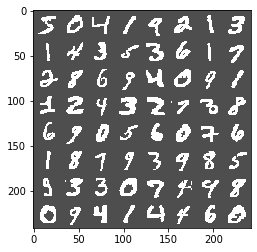

In [4]:
# visualize one

imgs = data_train.data[:64].view(-1, 1, 28, 28)
img = torchvision.utils.make_grid(imgs)

img = img.numpy().transpose(1, 2, 0)
img = img * 0.1307 + 0.3081

print(data_train.targets[:64].view(8, 8))
plt.imshow(img)

## Models
CNNModel can be used for fun, but our feature extraction model is based on FCModel.

FCModel:
28*28  ->  32      -> 10
Image  -> H(idden) -> Classes

In [5]:
class CNNModel(torch.nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(1, 16, 3, padding = 1),
                                   nn.ReLU(),
                                   nn.Conv2d(16, 32, 3, padding = 1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(2))
        self.dense = nn.Sequential(nn.Linear(14 * 14 * 32, 256),
                                   nn.ReLU(),
                                   nn.Dropout(p = 0.5),
                                   nn.Linear(256, 10))

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(-1, 14 * 14 * 32)
        x = self.dense(x)
        return x

In [6]:
class FCModel(torch.nn.Module):
    def __init__(self):
        super(FCModel, self).__init__()
        self.dense1 = nn.Sequential(nn.Linear(28 * 28, 32),
                                    nn.ReLU())
        self.dense2 = nn.Linear(32, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

In [12]:
# this implements the train process

model = FCModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

model

FCModel(
  (dense1): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
  )
  (dense2): Linear(in_features=32, out_features=10, bias=True)
)

In [13]:
n_epochs = 10

model.eval()
testing_correct = 0
for X_test, y_test in test_loader:
    X_test = X_test.to(device)
    y_test = y_test.to(device)

    outputs = model(X_test)
    y_pred = torch.max(outputs, 1).indices
    testing_correct += torch.sum(y_pred == y_test).item()

print('Initial Test Acc {:.4f}%'.format(testing_correct / len(data_test) * 100))

for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch, n_epochs))

    model.train()
    running_loss = 0.0
    running_correct = 0
    for X_train, y_train in train_loader:
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_train)
        y_pred = torch.max(outputs, 1).indices
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_correct += torch.sum(y_pred == y_train).item()

    model.eval()
    testing_correct = 0
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        
        outputs = model(X_test)
        y_pred = torch.max(outputs, 1).indices
        testing_correct += torch.sum(y_pred == y_test).item()

    print('Loss: {:.4f}, Train Acc {:.4f}%, Test Acc {:.4f}%'.format(
        running_loss / len(data_train),
        running_correct / len(data_train) * 100,
        testing_correct / len(data_test) * 100
    ))

Initial Test Acc 9.9500%
Epoch 0/10


Loss: 0.0056, Train Acc 89.7283%, Test Acc 93.1400%
Epoch 1/10


Loss: 0.0032, Train Acc 94.0533%, Test Acc 94.9600%
Epoch 2/10


Loss: 0.0026, Train Acc 95.2017%, Test Acc 95.1300%
Epoch 3/10


Loss: 0.0022, Train Acc 95.9917%, Test Acc 95.4200%
Epoch 4/10


Loss: 0.0019, Train Acc 96.3383%, Test Acc 95.8300%
Epoch 5/10


Loss: 0.0017, Train Acc 96.7283%, Test Acc 95.8500%
Epoch 6/10


Loss: 0.0016, Train Acc 96.9283%, Test Acc 96.0900%
Epoch 7/10


Loss: 0.0015, Train Acc 97.1317%, Test Acc 96.0300%
Epoch 8/10


Loss: 0.0014, Train Acc 97.2817%, Test Acc 96.1700%
Epoch 9/10


Loss: 0.0013, Train Acc 97.4783%, Test Acc 96.2200%


Model 1 Training process:

```
Initial Test Acc 5.8100%
Epoch 0/10
Loss: 0.0053, Train Acc 90.3600%, Test Acc 94.4300%
Epoch 1/10
Loss: 0.0027, Train Acc 94.9483%, Test Acc 95.4500%
Epoch 2/10
Loss: 0.0021, Train Acc 95.9867%, Test Acc 95.9300%
Epoch 3/10
Loss: 0.0018, Train Acc 96.6217%, Test Acc 96.2000%
Epoch 4/10
Loss: 0.0016, Train Acc 96.9967%, Test Acc 96.6500%
Epoch 5/10
Loss: 0.0014, Train Acc 97.2300%, Test Acc 96.2900%
Epoch 6/10
Loss: 0.0013, Train Acc 97.4533%, Test Acc 96.6700%
Epoch 7/10
Loss: 0.0012, Train Acc 97.7667%, Test Acc 96.9100%
Epoch 8/10
Loss: 0.0011, Train Acc 97.8100%, Test Acc 96.5300%
Epoch 9/10
Loss: 0.0010, Train Acc 98.0917%, Test Acc 96.9600%
```

Model 2 Training process:
```
Initial Test Acc 9.9500%
Epoch 0/10
Loss: 0.0056, Train Acc 89.7283%, Test Acc 93.1400%
Epoch 1/10
Loss: 0.0032, Train Acc 94.0533%, Test Acc 94.9600%
Epoch 2/10
Loss: 0.0026, Train Acc 95.2017%, Test Acc 95.1300%
Epoch 3/10
Loss: 0.0022, Train Acc 95.9917%, Test Acc 95.4200%
Epoch 4/10
Loss: 0.0019, Train Acc 96.3383%, Test Acc 95.8300%
Epoch 5/10
Loss: 0.0017, Train Acc 96.7283%, Test Acc 95.8500%
Epoch 6/10
Loss: 0.0016, Train Acc 96.9283%, Test Acc 96.0900%
Epoch 7/10
Loss: 0.0015, Train Acc 97.1317%, Test Acc 96.0300%
Epoch 8/10
Loss: 0.0014, Train Acc 97.2817%, Test Acc 96.1700%
Epoch 9/10
Loss: 0.0013, Train Acc 97.4783%, Test Acc 96.2200%
```

In [14]:
# Please train two models using two different random initial weights, then save them like:
# ./models/FC1.pt
# ./models/FC2.pt

torch.save(model.state_dict(), 'models/FC2.pt')

## Classifier

This section trains a classifier that, given a hidden feature representation (32-dimensional vector), then recognize which model it comes from.

In [15]:
# separation model

class ClassifyModel(nn.Module):
    def __init__(self):
        super(ClassifyModel, self).__init__()
        self.dense1 = nn.Sequential(nn.Linear(32, 16),
                                    nn.ReLU())
        self.dense2 = nn.Linear(16, 1)

    def forward(self, x):
        x = x.view(-1, 32)
        x = self.dense1(x)
        x = self.dense2(x)
        return x

In [16]:
model1 = FCModel().to(device)
model2 = FCModel().to(device)

model1.load_state_dict(torch.load('models/FC1.pt'))
model2.load_state_dict(torch.load('models/FC2.pt'))

model1.eval()
model2.eval()

FCModel(
  (dense1): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
  )
  (dense2): Linear(in_features=32, out_features=10, bias=True)
)

In [17]:
model_c = ClassifyModel().to(device)
criterion_c = nn.BCEWithLogitsLoss()
optimizer_c = torch.optim.Adam(model_c.parameters())

model_c

ClassifyModel(
  (dense1): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ReLU()
  )
  (dense2): Linear(in_features=16, out_features=1, bias=True)
)

In [18]:
# utilities for data preprocessing

def hiddenlayer_classify_data(loader):
    for X, _ in loader:
        X = X.to(device).view(-1, 28 * 28)
        F1 = model1.dense1(X).detach()
        F2 = model2.dense1(X).detach()
        H = torch.cat((F1, F2), 0)
        c1 = torch.zeros(len(X), 1, device = device)
        c2 = torch.ones(len(X), 1, device = device)
        c = torch.cat((c1, c2), 0)
        yield H, c

def hiddenlayer_conversion_data(loader):
    for X, _ in loader:
        X = X.to(device).view(-1, 28 * 28)
        F1 = model1.dense1(X).detach()
        F2 = model2.dense1(X).detach()
        yield F1, F2

In [19]:
model_c.eval()
testing_correct = 0
for H_test, c_test in hiddenlayer_classify_data(test_loader):
    outputs = model_c(H_test)
    c_pred = (outputs > 0)
    testing_correct += torch.sum(c_pred == c_test).item()

print('Initial Test Acc {:.4f}%'.format(testing_correct / (2 * len(data_test)) * 100))

n_epochs = 10

for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch, n_epochs))

    model_c.train()
    running_loss = 0.0
    running_correct = 0
    for H_train, c_train in hiddenlayer_classify_data(train_loader):
        optimizer_c.zero_grad()
        outputs = model_c(H_train)
        c_pred = (outputs > 0)
        loss = criterion_c(outputs, c_train)
        loss.backward()
        optimizer_c.step()

        running_loss += loss.item()
        running_correct += torch.sum(c_pred == c_train).item()

    model_c.eval()
    testing_correct = 0
    for H_test, c_test in hiddenlayer_classify_data(test_loader):
        outputs = model_c(H_test)
        c_pred = (outputs > 0)
        testing_correct += torch.sum(c_pred == c_test).item()

    print('Loss: {:.4f}, Train Acc {:.4f}%, Test Acc {:.4f}%'.format(
        running_loss / len(data_train),
        running_correct / (2 * len(data_train)) * 100,
        testing_correct / (2 * len(data_test)) * 100
    ))

Initial Test Acc 30.9600%
Epoch 0/10


Loss: 0.0008, Train Acc 98.0467%, Test Acc 99.9300%
Epoch 1/10


Loss: 0.0000, Train Acc 99.9483%, Test Acc 99.9850%
Epoch 2/10


Loss: 0.0000, Train Acc 99.9658%, Test Acc 99.9900%
Epoch 3/10


Loss: 0.0000, Train Acc 99.9750%, Test Acc 99.9950%
Epoch 4/10


Loss: 0.0000, Train Acc 99.9825%, Test Acc 99.9850%
Epoch 5/10


Loss: 0.0000, Train Acc 99.9842%, Test Acc 99.9950%
Epoch 6/10


Loss: 0.0000, Train Acc 99.9908%, Test Acc 99.9950%
Epoch 7/10


Loss: 0.0000, Train Acc 99.9908%, Test Acc 99.9950%
Epoch 8/10


Loss: 0.0000, Train Acc 99.9933%, Test Acc 99.9900%
Epoch 9/10


Loss: 0.0000, Train Acc 99.9967%, Test Acc 99.9900%


In [20]:
torch.save(model_c.state_dict(), 'models/Classifier12.pt')

## Converter

This section tries to map a hidden feature from the first model to the second one.
There are 3 different objectives we can consider:

1. Make the mapped feature distribution indistinguishable from the distribution of real features from the second model: an adversary loss
2. One-on-one Regression loss.
3. Embed the converter and ensemble a mixed model, then train this model with all weights fixed except the converter weights: end-to-end loss

*We didn't try method 1. Below we tried method 2 and method 3.*

In [22]:
class ConversionModel(nn.Module):
    def __init__(self):
        super(ConversionModel, self).__init__()
        self.dense1 = nn.Sequential(nn.Linear(32, 32),
                                    nn.ReLU())
        self.dense2 = nn.Linear(32, 32)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.view(-1, 32)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.relu(x)
        return x

class EnsembleModel(nn.Module):
    def __init__(self, model1, model2, model_12):
        super(EnsembleModel, self).__init__()
        self.dense1 = model1.dense1
        self.convert = model_12
        self.dense2 = model2.dense2

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        h1 = self.dense1(x)
        h2 = self.convert(h1)
        y = self.dense2(h2)
        return y

In [28]:
model_r_1to2 = ConversionModel().to(device)
criterion_r = nn.MSELoss()
optimizer_r = torch.optim.Adam(model_r_1to2.parameters())

model_r_1to2

ConversionModel(
  (dense1): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
  )
  (dense2): Linear(in_features=32, out_features=32, bias=True)
  (relu): ReLU()
)

In [29]:
model_1e2 = EnsembleModel(model1, model2, model_r_1to2)
model_1e2

EnsembleModel(
  (dense1): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
  )
  (convert): ConversionModel(
    (dense1): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
    )
    (dense2): Linear(in_features=32, out_features=32, bias=True)
    (relu): ReLU()
  )
  (dense2): Linear(in_features=32, out_features=10, bias=True)
)

In [25]:
# Utility for testing the accuracy of ensembling

def test_acc(model):
    running_correct = 0
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        outputs = model(X_test)
        y_pred = torch.max(outputs, 1).indices
        running_correct += torch.sum(y_pred == y_test).item()

    return running_correct / len(data_test)

In [26]:
# Train method 2: Direct Regression

model_r_1to2.eval()
testing_running_loss = 0.0
for H_test_1, H_test_2 in hiddenlayer_conversion_data(test_loader):
    outputs = model_r_1to2(H_test_1)
    testing_running_loss += criterion_r(outputs, H_test_2).item() * len(H_test_1)

print('Initial Test Loss: {:.4f}, Ensembled Test Acc {:.4f}%'.format(
    testing_running_loss / len(data_test),
    100 * test_acc(model_1e2)
))

n_epochs = 20

for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch, n_epochs))

    model_r_1to2.train()
    running_loss = 0.0
    for H_train_1, H_train_2 in hiddenlayer_conversion_data(train_loader):
        optimizer_r.zero_grad()
        outputs = model_r_1to2(H_train_1)
        loss = criterion_r(outputs, H_train_2)
        loss.backward()
        optimizer_r.step()

        running_loss += loss.item() * len(H_train_1)

    model_r_1to2.eval()
    testing_running_loss = 0.0
    for H_test_1, H_test_2 in hiddenlayer_conversion_data(test_loader):
        outputs = model_r_1to2(H_test_1)
        testing_running_loss += criterion_r(outputs, H_test_2).item() * len(H_test_1)

    print('Train Loss: {:.4f}, Test Loss: {:.4f}, Ensembled Test Acc {:.4f}%'.format(
        running_loss / len(data_train),
        testing_running_loss / len(data_test),
        100 * test_acc(model_1e2)
    ))

Initial Test Loss: 42.3663, Ensembled Test Acc 10.9700%
Epoch 0/20


Train Loss: 9.0727, Test Loss: 4.6716, Ensembled Test Acc 92.8200%
Epoch 1/20


Train Loss: 4.4691, Test Loss: 4.3823, Ensembled Test Acc 93.3900%
Epoch 2/20


Train Loss: 4.3109, Test Loss: 4.3341, Ensembled Test Acc 93.0500%
Epoch 3/20


Train Loss: 4.2283, Test Loss: 4.2037, Ensembled Test Acc 93.2600%
Epoch 4/20


Train Loss: 4.1676, Test Loss: 4.1418, Ensembled Test Acc 93.4700%
Epoch 5/20


Train Loss: 4.1162, Test Loss: 4.1090, Ensembled Test Acc 93.4500%
Epoch 6/20


Train Loss: 4.0652, Test Loss: 4.0909, Ensembled Test Acc 93.6500%
Epoch 7/20


Train Loss: 4.0185, Test Loss: 4.0196, Ensembled Test Acc 93.4200%
Epoch 8/20


Train Loss: 3.9777, Test Loss: 3.9692, Ensembled Test Acc 93.7200%
Epoch 9/20


Train Loss: 3.9435, Test Loss: 3.9444, Ensembled Test Acc 93.6000%
Epoch 10/20


Train Loss: 3.9126, Test Loss: 3.9161, Ensembled Test Acc 93.6200%
Epoch 11/20


Train Loss: 3.8917, Test Loss: 3.8942, Ensembled Test Acc 93.6900%
Epoch 12/20


Train Loss: 3.8702, Test Loss: 3.8830, Ensembled Test Acc 93.5300%
Epoch 13/20


Train Loss: 3.8507, Test Loss: 3.8843, Ensembled Test Acc 93.6900%
Epoch 14/20


Train Loss: 3.8328, Test Loss: 3.8363, Ensembled Test Acc 93.4600%
Epoch 15/20


Train Loss: 3.8200, Test Loss: 3.8421, Ensembled Test Acc 93.2900%
Epoch 16/20


Train Loss: 3.8029, Test Loss: 3.8153, Ensembled Test Acc 93.4500%
Epoch 17/20


Train Loss: 3.7879, Test Loss: 3.8105, Ensembled Test Acc 93.7300%
Epoch 18/20


Train Loss: 3.7750, Test Loss: 3.7952, Ensembled Test Acc 93.3700%
Epoch 19/20


Train Loss: 3.7624, Test Loss: 3.7777, Ensembled Test Acc 93.3900%


In [27]:
torch.save(model_r_1to2.state_dict(), 'models/Converter1to2_Regression.pt')

In [30]:
# Train method 3: End-to-end

# before training, make sure you re-init:
#  1. your converter above, AND
#  2. the ensembled model above, AND
#  3. the optimizer below.
# don't forget any of these!

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_r_1to2.parameters())  # train converter only
n_epochs = 10

In [31]:
# this code is nearly the same as one above cell where we trained a simple model
print('Initial Test Acc {:.4f}%'.format(100 * test_acc(model_1e2)))

for epoch in range(n_epochs):
    print('Epoch {}/{}'.format(epoch, n_epochs))

    model_1e2.train()
    running_loss = 0.0
    running_correct = 0
    for X_train, y_train in train_loader:
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
        optimizer.zero_grad()
        outputs = model_1e2(X_train)
        y_pred = torch.max(outputs, 1).indices
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_correct += torch.sum(y_pred == y_train).item()

    model_1e2.eval()
    testing_correct = 0
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        
        outputs = model_1e2(X_test)
        y_pred = torch.max(outputs, 1).indices
        testing_correct += torch.sum(y_pred == y_test).item()

    print('Loss: {:.4f}, Train Acc {:.4f}%, Test Acc {:.4f}%'.format(
        running_loss / len(data_train),
        running_correct / len(data_train) * 100,
        testing_correct / len(data_test) * 100
    ))

Initial Test Acc 20.8600%
Epoch 0/10


Loss: 0.0032, Train Acc 94.1283%, Test Acc 96.4400%
Epoch 1/10


Loss: 0.0010, Train Acc 98.0017%, Test Acc 96.6300%
Epoch 2/10


Loss: 0.0009, Train Acc 98.1950%, Test Acc 96.8200%
Epoch 3/10


Loss: 0.0008, Train Acc 98.3800%, Test Acc 97.0000%
Epoch 4/10


Loss: 0.0008, Train Acc 98.4083%, Test Acc 96.7900%
Epoch 5/10


Loss: 0.0008, Train Acc 98.4450%, Test Acc 96.7700%
Epoch 6/10


Loss: 0.0007, Train Acc 98.4800%, Test Acc 97.1000%
Epoch 7/10


Loss: 0.0007, Train Acc 98.4583%, Test Acc 96.8100%
Epoch 8/10


Loss: 0.0007, Train Acc 98.5300%, Test Acc 96.7900%
Epoch 9/10


Loss: 0.0007, Train Acc 98.5333%, Test Acc 97.1900%


In [32]:
torch.save(model_r_1to2.state_dict(), 'models/Converter1to2_EndtoEnd.pt')